# Data Synchronization

Updated on: 09.01.2025 </br>

Main changes: New Synchronization Method between EMG and Ultrasound, tests conducted with oscilloscope.

Protocol: sending a pulse evert 10 seconds, to detect if there is a mis-alignment over time

In [1]:
import sys

sys.path.append(r'C:\Users\giusy\OneDrive\Desktop\HGR\manus-acquisition\data_synchronization')
from biogui_utils import *
from pathlib import Path

%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
data_directory = Path(r"C:\Users\giusy\OneDrive\Desktop\HGR\biogui\synch_tests")


In [3]:
acq_names =  ["2025-01-09_18-36-01",     # pulse 5ms width at random times (wulpus USB powered)
              "2025-01-10_08-46-21",    # move away from the dongle (battery)
              "2025-01-10_09-49-49",    # close to dongle --> move away --> close       
            "2025-01-10_10-07-29",      # close as in 0
            "2025-01-10_11-09-22",      # protocol rep 1, latopt not connected to power
            "2025-01-10_11-17-01",      #protocol rep2, laptop connected to power
            "2025-01-10_11-32-26",      # protocol without utting away, after power cycling everythin
            "2025-01-10_11-44-12",      # pulkses every 10 seconds, WULPUS USB powered. Acquisitions stopped before
            "2025-01-10_11-51-47",      #pulses every 10 seconds close to dongle, WULPUS USB powered. Laptop powered, WULPUS run till the end (4000  acqu)--> seems to be okay
            "2025-01-10_12-01-25",      # same as before, close to dongle, WULPUS battery powered, laptop powered, WULPUS runs til the end (4000 acq) --> okay
            "2025-01-10_12-05-27",       # same as before, close to dongle, WULPUS battery powered, laptop not powered, WULPUS runs til the end (4000 acq)
            "2025-01-10_12-11-40",      # protocol, wulpus battery powered, latopt not powered, wulus runs till the end
            "2025-01-10_12-23-17"]      # 16000 acquisitions, always close to dongle --> worked

wulpus_files = ["wulpus_2025-01-09_18-36-01.npz",   # sine wave at random times 
                "wulpus_2025-01-10_08-46-21.npz", # distance 2m from input -> BLE losses 
                "wulpus_2025-01-10_09-49-49.npz", 
                "wulpus_2025-01-10_10-07-29.npz", 
                "wulpus_2025-01-10_11-09-22.npz", 
                "wulpus_2025-01-10_11-17-01.npz", 
                "wulpus_2025-01-10_11-32-26.npz", 
                "wulpus_2025-01-10_11-44-12.npz", 
                 "wulpus_2025-01-10_11-51-47.npz",
                 "wulpus_2025-01-10_12-01-25.npz", 
                 "wulpus_2025-01-10_12-05-27.npz", 
                 "wulpus_2025-01-10_12-11-40.npz", 
                 "wulpus_2025-01-10_12-23-17.npz"]
                       
                                         
#wulpus_num_acquisitions = 5000

In [4]:
acq_idx = len(wulpus_files) -2
#print(acq_idx)
#acq_idx=

In [5]:
acq_name = acq_names[acq_idx]

print(f'Data main directory: {data_directory}')
emg_file = data_directory/f"emg_{acq_name}.bin"
wulpus_trigger = data_directory/f"triggerWulpus_{acq_name}.bin"
counter_file = data_directory/f"counter_{acq_name}.bin"


Data main directory: C:\Users\giusy\OneDrive\Desktop\HGR\biogui\synch_tests


In [6]:
    
# Create dataframe containing acquired EMG data
print('Processing EMG data...\n')
fs_emg = 500
if fs_emg is not None:
    print(f'EMG data sampled at: {fs_emg} Hz')
else:
    fs_emg = 500
    print(f'Using default EMG sampling rate: 500 Hz')

EMG_Dataset = EMG_dataset(emg_file, num_channels=8, trigger_gui=False, fs_emg=fs_emg, filter=True)
emg_df_raw = EMG_Dataset.emg_raw_df.reset_index()


emg_df_filt = EMG_Dataset.emg_filter_df.reset_index()
# Originally it increases every 2 ms, now set progressive indexes

emg_df = emg_df_raw



Processing EMG data...

EMG data sampled at: 500 Hz
Created EMG dataframe with columns:Index(['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8', 'Timestamp',
       'Timestamp_reconstructed'],
      dtype='object')


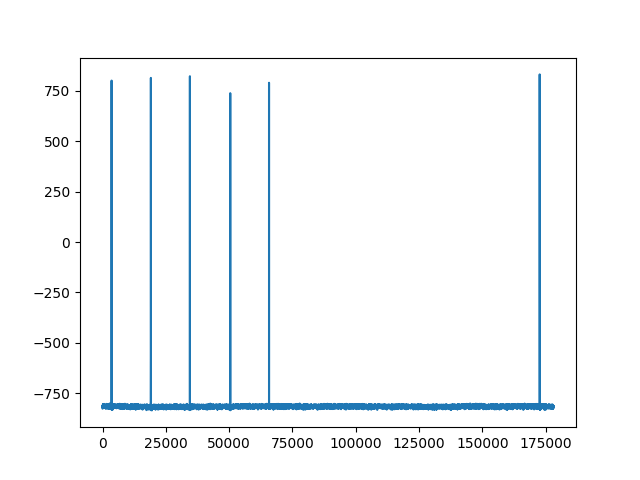

In [7]:
plt.figure()
plt.plot(emg_df_raw['Ch1'])
#plt.plot(emg_df_filt['Ch1'], linestyle='--')




In [8]:
trans_idx = emg_df_raw['Ch1'].diff() 
idx_threhsold = 1000
emg_idx = trans_idx[trans_idx > 700].index
emg_idx

Index([3572, 19091, 34507, 50450, 65769, 65770, 172687], dtype='int64')

In [9]:
emg_idx_effect = [emg_idx[0]]

for cnt_idx, curr_idx in enumerate(emg_idx[1:]):
    if curr_idx == emg_idx[cnt_idx] + 1:
        print(f'previous:{emg_idx[cnt_idx]}')
        print(f'current:{curr_idx}')
    else:
        print(f'First idx: {curr_idx}')
        emg_idx_effect.append(curr_idx)

First idx: 19091
First idx: 34507
First idx: 50450
First idx: 65769
previous:65769
current:65770
First idx: 172687


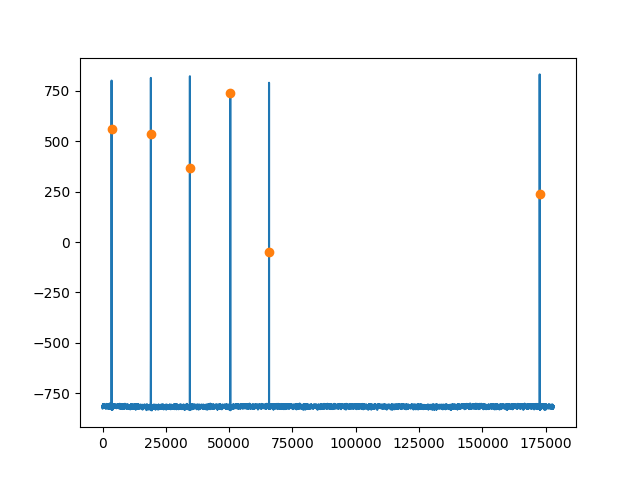

In [10]:
plt.figure()
plt.plot(emg_df_raw['Ch1'])
plt.plot(emg_idx_effect, emg_df_raw.loc[emg_idx_effect, 'Ch1'], marker='o', linestyle='none')

In [11]:
emg_idx_effect

# we are sending a pulse every 10 seconds
# hence, we should expect a difference of 5000 samples between pulses
# we always get 10 samples more -> this is due to the fact that the ADS samples faster than we are expecting
np.diff(emg_idx_effect)



array([ 15519,  15416,  15943,  15319, 106918], dtype=int64)

In [12]:
def read_counter(filePath, trigger_gui=True):
    '''
    filePath: str
    Note: File Containing Counter for BIOGAP data
    '''
    # Read data
    with open(filePath, "rb") as f:
        nCh = struct.unpack("<I", f.read(4))[0]
        bSig = bytes(f.read())
    sig = np.frombuffer(bSig, dtype='float32').reshape(-1, nCh).T
    data = sig.T

    # Data Contains: Counter (updated every BLE packet - every 14 ms), Progressive Counter, 
    # Wulpus Counter (Not in use atm), Timestamps

    # Considering for now only the progressive counter, the trigger gui and the timestamps
    if trigger_gui == True:
        counter_df = pd.DataFrame()
        # If we keep the GUI open, counter doesn't start from 0
        # TODO: change the FW
        counter_df['EMG_counter_header'] = data[:, 0]
        counter_df["EMG_counter"] = data[:, 1] - data[0, 1]
        counter_df["Trigger_gui"] = data[:, -2]
        counter_df["Timestamp"] = data[:, -1]

    else:
        counter_df['EMG_counter_header'] = data[:, 0]
        counter_df = pd.DataFrame()
        counter_df["EMG_counter"] = data[:, 1] - data[0, 1]
        counter_df["Timestamp"] = data[:, -1]

        
    return counter_df

In [13]:
## Extract file that contains the counter
counter_df = read_counter(counter_file, trigger_gui=True)

In [14]:
counter_df['EMG_counter']

0              0.0
1              1.0
2              2.0
3              3.0
4              4.0
            ...   
178124    178124.0
178125    178125.0
178126    178126.0
178127    178127.0
178128    178128.0
Name: EMG_counter, Length: 178129, dtype: float32

In [15]:
counter_df['EMG_counter_header'].diff()!=0

0          True
1         False
2         False
3         False
4         False
          ...  
178124    False
178125    False
178126    False
178127    False
178128    False
Name: EMG_counter_header, Length: 178129, dtype: bool

In [16]:
# check where the sequence restarts

# This filters the counter for every BLE packet (expected indexes to have an increase of 7 samples)
new_packet_locs = counter_df['EMG_counter_header'][counter_df['EMG_counter_header'].diff() !=0].iloc[1:]


In [17]:
# We expect an increase of 7 

np.where(np.diff(new_packet_locs.index)!=7)

(array([], dtype=int64),)

In [18]:
np.diff(new_packet_locs.index)


array([7, 7, 7, ..., 7, 7, 7], dtype=int64)

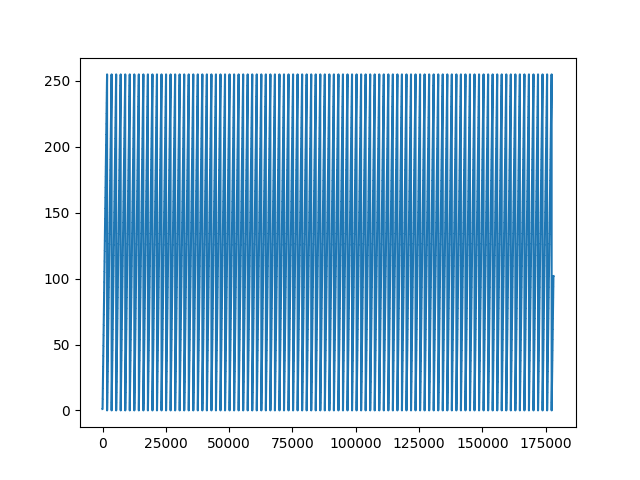

In [19]:
plt.figure()
plt.plot(counter_df['EMG_counter_header'])

In [20]:
# Get the unique timestamps and their counts
unique_timestamps, counts = np.unique(emg_df['Timestamp'], return_counts=True)

# Initialize the reconstructed timestamp list
reconstructed_time = np.linspace(unique_timestamps[0] - 0.002*counts[0], unique_timestamps[0], counts[0])

# Start from the first unique timestamp minus a small step (for extrapolation if necessary)
prev_timestamp = reconstructed_time[-1]

# Loop through unique timestamps and interpolate
for i, (current_timestamp, count) in enumerate(zip(unique_timestamps[1:], counts[1:])):
    # Interpolate linearly between the previous last timestamp and the current unique timestamp
    interpolated = np.linspace(prev_timestamp, current_timestamp, count+1, endpoint=True)
    reconstructed_time = np.append(reconstructed_time, interpolated[1:])
    
    # Update the previous timestamp for the next iteration
    prev_timestamp = interpolated[-1]



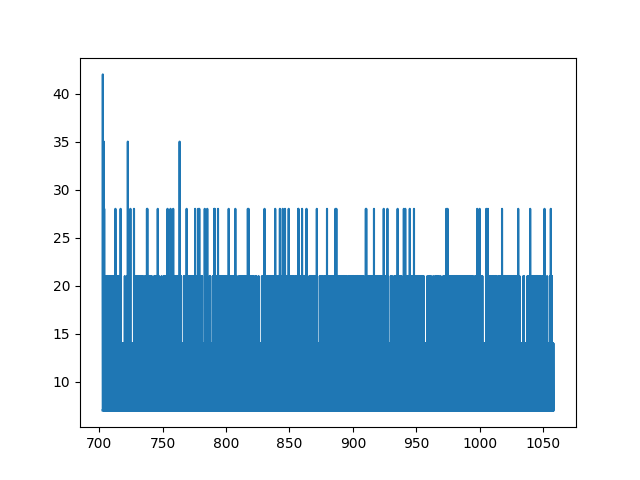

In [21]:
plt.figure()
plt.plot(unique_timestamps, counts)
plt.show()

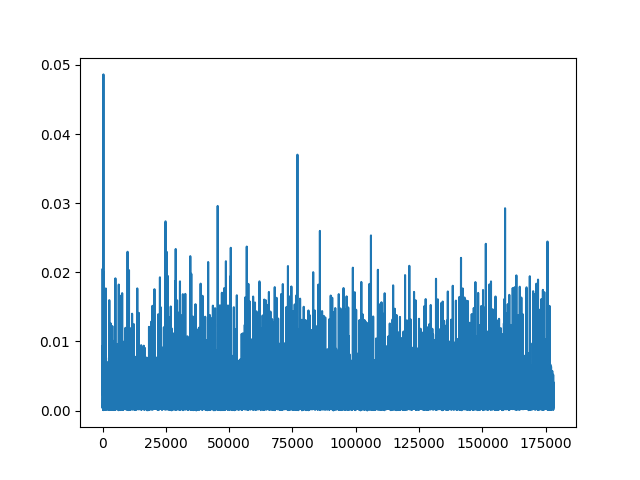

In [22]:
plt.figure()
plt.plot(np.diff(emg_df['Timestamp_reconstructed']))
plt.show()

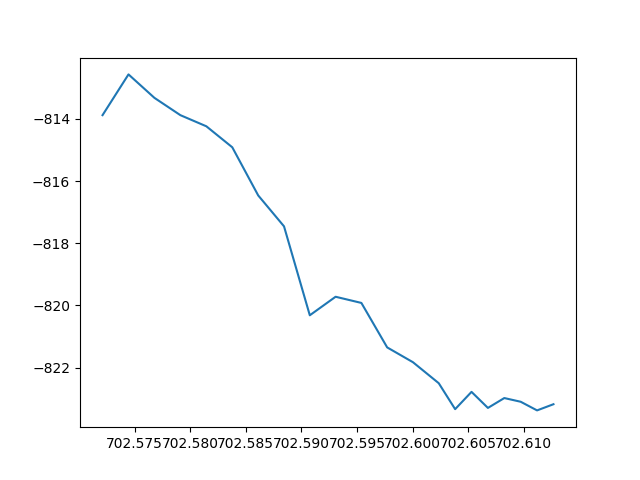

In [23]:
plt.figure()
plt.plot(emg_df['Timestamp_reconstructed'].iloc[:21], emg_df['Ch1'].iloc[:21])

In [24]:
def read_trigger_wulpus_new(filePath, trigger_gui=True):
    '''
    filePath: str
    Note: we are WULPUS trigger synchronization signal
    '''
    # Read data
    with open(filePath, "rb") as f:
        nCh = struct.unpack("<I", f.read(4))[0]
        bSig = bytes(f.read())
    
    # Trigger Wulpus New stores in the MSB the Synchronization Signal 
    sig = np.frombuffer(bSig, dtype='float32').reshape(-1, nCh).T
    data = sig.T
    if trigger_gui == True:
    # Extracting also trigger information 
        columns = ["Trigger_Wulpus", "Trigger_gui", "Timestamp"]
        trigger_df = pd.DataFrame(data, columns=columns)

    else:
    # Extracting also trigger information 
        columns = ["Trigger_Wulpus", "Timestamp"]
        trigger_df = pd.DataFrame(data, columns=columns)
        
    return trigger_df


In [25]:
trigger_wulpus_df = read_trigger_wulpus_new(wulpus_trigger, trigger_gui=False)


In [26]:
trigger_wulpus_df

Trigger_Wulpus    Timestamp
0                  0.0   702.586121
1                  0.0   702.586121
2                  0.0   702.586121
3                  0.0   702.586121
4                  0.0   702.586121
...                ...          ...
178124             1.0  1058.184937
178125             1.0  1058.184937
178126             1.0  1058.184937
178127             1.0  1058.184937
178128             1.0  1058.184937

[178129 rows x 2 columns]

In [27]:
np.diff(counter_df['EMG_counter'])

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [28]:
emg_df = pd.concat((emg_df, trigger_wulpus_df['Trigger_Wulpus'], counter_df['EMG_counter']), axis=1)

In [29]:
emg_df

index         Ch1           Ch2          Ch3          Ch4        Ch5  \
0            0 -813.881531   -199.039780 -3792.007812   122.030579 -51.816303   
1            2 -812.570251  -1677.076050 -3811.478516  -258.962311 -51.935513   
2            4 -813.325256  -5650.361328 -4373.947754   202.377640 -51.657360   
3            6 -813.881531 -14209.310547 -5076.766113   931.819275 -51.657360   
4            8 -814.239197 -24326.841797 -5629.896973  1591.682373 -52.014988   
...        ...         ...           ...          ...          ...        ...   
178124  356248 -818.173096 -32116.810547 -6041.248535  2276.817871 -51.935513   
178125  356250 -817.418091 -39075.691406 -6102.760742  2407.590576 -51.935513   
178126  356252 -818.212830 -40676.156250 -6114.999512  2499.262451 -51.776569   
178127  356254 -819.325439 -28553.287109 -6008.227539  2389.192627 -51.697094   
178128  356256 -819.444641  -4746.158691 -5094.170410  1625.974976 -51.736832   

              Ch6        Ch7          Ch8    Timestamp  \
0      -54.319698 -83.009399 -4198.869141   702.586121   
1      -54.200489 -82.731247 -4157.304688   702.586121   
2      -54.399174 -83.088875 -4232.247559   702.586121   
3      -54.518383 -83.088875 -4328.648438   702.586121   
4      -54.677326 -82.612038 -4417.379883   702.586121   
...           ...        ...          ...          ...   
178124 -54.756802 -83.287560 -4703.323242  1058.184937   
178125 -54.836273 -83.327293 -4693.547852  1058.184937   
178126 -54.836273 -83.287560 -4688.660156  1058.184937   
178127 -54.597855 -83.287560 -4652.380859  1058.184937   
178128 -54.558117 -83.009399 -4569.172852  1058.184937   

        Timestamp_reconstructed  Trigger_Wulpus  EMG_counter  
0                    702.572121             0.0          0.0  
1                    702.574454             0.0          1.0  
2                    702.576787             0.0          2.0  
3                    702.579121             0.0          3.0  
4                    702.581454             0.0          4.0  
...                         ...             ...          ...  
178124              1058.172450             1.0     178124.0  
178125              1058.175572             1.0     178125.0  
178126              1058.178693             1.0     178126.0  
178127              1058.181815             1.0     178127.0  
178128              1058.184937             1.0     178128.0  

[178129 rows x 13 columns]

In [30]:
# Now, check EMG Ble losses
#Count BLE losses 
emg_losses= np.where(np.diff(emg_df['EMG_counter'])!=1)[0]
count_emg_losses = (len(emg_losses))
print(f"Lost:{count_emg_losses} BIOGAP packets")


Lost:0 BIOGAP packets


In [31]:
# 50 us samples -> 500 emg samples


In [32]:
# Define Now Ultrasound locations
# We get a trigger Signal every 50 Ultrasound frames
wps_trigger_diff = emg_df['Trigger_Wulpus'].diff()             # note .diff() already takes into account the first element (set to NaN)
wulpus_50_locs = wps_trigger_diff!=0 
print(wulpus_50_locs)      

0          True
1         False
2         False
3         False
4         False
          ...  
178124    False
178125    False
178126    False
178127    False
178128    False
Name: Trigger_Wulpus, Length: 178129, dtype: bool


In [33]:
idx_wulpus = wps_trigger_diff[wps_trigger_diff!=0].index.values
# add the initial index manually (change the FW to send first trigger at the first pulse and not after 50)
#idx_wulpus[0] = idx_wulpus[1] - 500
print(idx_wulpus)
if idx_wulpus[0] == 0:
    idx_wulpus = idx_wulpus[1:]

[     0   2869   3370   3871   4371   4872   5373   5873   6374   6875
   7375   7876   8377   8877   9378   9879  10379  10880  11380  11881
  12382  12882  13383  13884  14384  14885  15386  15886  16387  16888
  17388  17889  18389  18890  19391  19891  20392  20893  21393  21894
  22394  22895  23396  23896  24397  24898  25398  25899  26399  26900
  27401  27901  28402  28903  29403  29904  30404  30905  31406  31906
  32407  32908  33408  33909  34409  34910  35411  35911  36412  36913
  37413  37914  38414  38915  39416  39916  40417  40917  41418  41919
  42419  42920  43420  43921  44422  44922  45423  45923  46424  46925
  47425  47926  48426  48927  49428  49928  50429  50930  51430  51931
  52431  52932  53433  53933  54434  54934  55435  55936  56436  56937
  57437  57938  58439  58939  59440  59941  60441  60942  61442  61943
  62444  62944  63445  63946  64446  64947  65447  65948  66449  66949
  67450  67951  68451  68952  69452  69953  70454  70954  71455  71955
  7245

In [34]:
idx_wulpus         # are the indices in the emg dataframe

array([  2869,   3370,   3871,   4371,   4872,   5373,   5873,   6374,
         6875,   7375,   7876,   8377,   8877,   9378,   9879,  10379,
        10880,  11380,  11881,  12382,  12882,  13383,  13884,  14384,
        14885,  15386,  15886,  16387,  16888,  17388,  17889,  18389,
        18890,  19391,  19891,  20392,  20893,  21393,  21894,  22394,
        22895,  23396,  23896,  24397,  24898,  25398,  25899,  26399,
        26900,  27401,  27901,  28402,  28903,  29403,  29904,  30404,
        30905,  31406,  31906,  32407,  32908,  33408,  33909,  34409,
        34910,  35411,  35911,  36412,  36913,  37413,  37914,  38414,
        38915,  39416,  39916,  40417,  40917,  41418,  41919,  42419,
        42920,  43420,  43921,  44422,  44922,  45423,  45923,  46424,
        46925,  47425,  47926,  48426,  48927,  49428,  49928,  50429,
        50930,  51430,  51931,  52431,  52932,  53433,  53933,  54434,
        54934,  55435,  55936,  56436,  56937,  57437,  57938,  58439,
      

In [35]:
np.diff(idx_wulpus)

array([501, 501, 500, 501, 501, 500, 501, 501, 500, 501, 501, 500, 501,
       501, 500, 501, 500, 501, 501, 500, 501, 501, 500, 501, 501, 500,
       501, 501, 500, 501, 500, 501, 501, 500, 501, 501, 500, 501, 500,
       501, 501, 500, 501, 501, 500, 501, 500, 501, 501, 500, 501, 501,
       500, 501, 500, 501, 501, 500, 501, 501, 500, 501, 500, 501, 501,
       500, 501, 501, 500, 501, 500, 501, 501, 500, 501, 500, 501, 501,
       500, 501, 500, 501, 501, 500, 501, 500, 501, 501, 500, 501, 500,
       501, 501, 500, 501, 501, 500, 501, 500, 501, 501, 500, 501, 500,
       501, 501, 500, 501, 500, 501, 501, 500, 501, 501, 500, 501, 500,
       501, 501, 500, 501, 501, 500, 501, 500, 501, 501, 500, 501, 501,
       500, 501, 500, 501, 501, 500, 501, 500, 501, 501, 500, 501, 501,
       500, 501, 500, 501, 501, 500, 501, 500, 501, 501, 500, 501, 500,
       501, 501, 500, 501, 501, 500, 501, 500, 501, 501, 500, 501, 501,
       500, 501, 500, 501, 501, 500, 501, 501, 500, 501, 500, 50

In [36]:
np.mean(np.diff(idx_wulpus))

500.62138728323697

In [37]:
# cut everthing after first wulpus frame
#emg_df = emg_df.loc[idx_wulpus[0]:, :]
# Reset the index such that we start from 0 for simplicity
#emg_df = emg_df.reset_index(drop=True)
#emg_df['index_from_0'] = emg_df.index.values - emg_df.index.values[0]
#emg_df


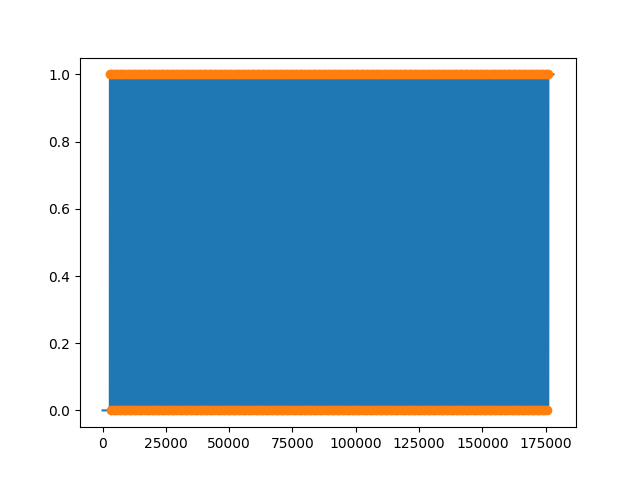

In [38]:
plt.figure()
plt.plot(emg_df['Trigger_Wulpus'])
plt.plot(idx_wulpus, emg_df['Trigger_Wulpus'].loc[idx_wulpus], marker='o', linestyle='none')
plt.show()

# every idx wulpus (dot) corresponds to the 50th - 100th ... etc ultrasound frame 


# Read Wulpus

In [39]:
from US_dataset import *

In [40]:
data = np.load(data_directory/wulpus_files[acq_idx])
acq_num_arr= data['acq_num_arr']

print(f'Max acq num arr:{np.max(acq_num_arr)}')
acquired_samples = np.where(acq_num_arr == np.max(acq_num_arr))[0][0]
expected_samples = np.max(acq_num_arr)

print(f'Acquired:{acquired_samples}')
print(f'Expected:{expected_samples}')
losts = expected_samples-acquired_samples
print(f'Lost:{losts}')
    
us_raw_data = data['data_arr']
us_raw_data = us_raw_data[:, :acquired_samples+1]
us_tx_idx_arr = data['tx_rx_id_arr']
us_tx_idx_arr = us_tx_idx_arr[:acquired_samples+1]
acq_num_arr = data['acq_num_arr'] [:acquired_samples+1]
print(f'last acq_num_arr:{acq_num_arr[-1]}')


Max acq num arr:17379
Acquired:15999
Expected:17379
Lost:1380
last acq_num_arr:17379


In [41]:
# the maximum index value should correspond to the last acquisition number array acquired 
# If we loose samples, the US data corresponding to this expected idx will be set to NaN
expected_idx = np.arange(acq_num_arr[-1]+1)
us_df = pd.DataFrame(index=expected_idx)

# assing data to the corresponding ultrasound frames
us_df.loc[acq_num_arr, 'Transducer'] = us_tx_idx_arr.astype(int)
# Assign 'Transducer_Data' column with arrays
us_raw_transp = us_raw_data.T
us_df.loc[acq_num_arr, 'Transducer_Data'] = pd.Series(list(us_raw_transp), index=acq_num_arr)

In [42]:
# Identify Locations with Nan Values, corresponding to BLE Losses for Wulpus
nan_locs = us_df[us_df['Transducer'].isna() == True].index




In [43]:
# dummy ultrasound data
#us_dummy = us_df.iloc[1]['Transducer_Data']
#us_df.loc[nan_locs, 'Transducer_Data'] = pd.Series([us_dummy for _ in range(len(nan_locs))], index=nan_locs)

In [44]:
us_df.loc[nan_locs]

us_df.loc[nan_locs, 'Missing_Tx'] = 1
us_df.loc[acq_num_arr, 'Missing_Tx'] = 0

In [45]:


test_acquisitions = True
for curr_nan in nan_locs:
    # check the value of the transducer at previous location
    prev_trans = us_df.loc[curr_nan-1, 'Transducer']
    print(f'previous trans value: {prev_trans}')
    if test_acquisitions:
        missing_trans_idx = 0
    else:
        if prev_trans == 3:
            missing_trans_idx = 0
        else:
            missing_trans_idx = prev_trans + 1
    us_df.loc[curr_nan, 'Transducer'] = missing_trans_idx
   
    print(us_df.loc[curr_nan, 'Transducer'])

previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous trans value: 0.0
0.0
previous t

In [46]:
# This is to check that we are handling correctly missing data
print(len(us_df[us_df['Missing_Tx']==1]))

1380


In [47]:
# the length of the rest should match the expected number of acquistions 
print(len(us_df[us_df['Missing_Tx']==0]))

16000


In [48]:
# now, we need to assing every batch of 50 ultrasound frames (1 second) to the corresponding batch of EMG data 
# combined_df = emg_df.copy()

# cnt_wulpus_batch = 0


# for idx_wulpus_cnt, idx_wulpus_biogap in enumerate(idx_wulpus):
#     #if idx_wulpus_biogap!=idx_wulpus[-1]:

#     if idx_wulpus_biogap!=idx_wulpus[-1]:
#         print(f'Batch number:{cnt_wulpus_batch}')
#         start_wulpus_batch = cnt_wulpus_batch * 50
#         stop_wulpus_batch = start_wulpus_batch + 49
#         print(f'Considering US frames from:{start_wulpus_batch} to {stop_wulpus_batch}')
#         us_df_curr = us_df.loc[start_wulpus_batch:stop_wulpus_batch]
#         print(f"Lost:{len(us_df_curr[us_df_curr['Transducer'].isna()==True])} US frames for this batch")
        
#         biogap_idx_start = idx_wulpus_biogap
#         biogap_idx_stop = idx_wulpus[idx_wulpus_cnt+1] -1
#         print(f'Num EMG samples in between: {biogap_idx_stop - biogap_idx_start}')

#         freq_scaling = 500 / 50
#         new_wps_idx = np.arange(biogap_idx_start, biogap_idx_stop, freq_scaling)
#         us_df_curr = us_df_curr.set_index(new_wps_idx)

#         combined_df.loc[new_wps_idx, 'Transducer'] = us_df_curr['Transducer']
#         combined_df.loc[new_wps_idx, 'Transducer_Data'] = us_df_curr['Transducer_Data']
#         cnt_wulpus_batch+=1
        
        
#     #else:
#         # enter here for the last (max) 50 samples acquired
#     #    print('last batch')
#     print('---')

In [49]:
# now, we need to assing every batch of 50 ultrasound frames (1 second) to the corresponding batch of EMG data 

freq_scaling = 500 / 50
counter_every_50_frames = 49                    # 
combined_df = emg_df.copy()

cnt_wulpus_batch = 0

wulpus_bloks = []
for idx_wulpus_cnt, idx_wulpus_biogap in enumerate(idx_wulpus):
    #if idx_wulpus_biogap!=idx_wulpus[-1]:

    
    print(f'Batch number:{cnt_wulpus_batch}')
    start_wulpus_batch = cnt_wulpus_batch * 50
    if idx_wulpus_biogap!=idx_wulpus[-1]:
        stop_wulpus_batch = start_wulpus_batch + 49
    else:
        stop_wulpus_batch = acq_num_arr[-1]
    print(f'Considering US frames from:{start_wulpus_batch} to {stop_wulpus_batch}')
    us_df_curr = us_df.loc[start_wulpus_batch:stop_wulpus_batch]
    print(f'Current US df has len: {len(us_df_curr)}')
    print(f"Lost:{len(us_df_curr[us_df_curr['Transducer_Data'].isna()==True])} US frames for this batch")
    
    # idx wulpus biogap corresponds to the 50th - 100th .... Ultrasound frame
    biogap_idx_start = idx_wulpus_biogap - counter_every_50_frames * freq_scaling                
    print(f'Biogap idx starts at: {biogap_idx_start}, stops at: {idx_wulpus_biogap}')
    print(f'Start - stop difference : {idx_wulpus_biogap - biogap_idx_start}')
    
    new_wps_idx = np.linspace(biogap_idx_start, idx_wulpus_biogap, num = len(us_df_curr), dtype=int)
    wulpus_bloks.extend([new_wps_idx[0], new_wps_idx[-1]])
    print(new_wps_idx)
    
    us_curr_acq_num_arr = us_df_curr.index
    print(us_curr_acq_num_arr)
    us_df_curr = us_df_curr.set_index(new_wps_idx)

    combined_df.loc[new_wps_idx, 'Transducer'] = us_df_curr['Transducer']
    combined_df.loc[new_wps_idx, 'Transducer_Data'] = us_df_curr['Transducer_Data']
    combined_df.loc[new_wps_idx, 'US acq_num_array'] =us_curr_acq_num_arr
    combined_df.loc[new_wps_idx, 'Missing_Tx'] = us_df_curr['Missing_Tx']
    #print(combined_df.loc[new_wps_idx, 'US acq_num_array'])
    cnt_wulpus_batch+=1
        
        
    #else:
        # enter here for the last (max) 50 samples acquired
    #    print('last batch')
    print('---')

# assign all the remainin samples
# start_wulpus_batch = cnt_wulpus_batch * 50
# stop_wulpus_batch = acq_num_arr[-1]
# us_df_curr = us_df.loc[start_wulpus_batch:]
# us_curr_acq_num_arr = us_df_curr.index
# print(f'Considering US frames from:{start_wulpus_batch} to {stop_wulpus_batch}')
# remaining_samples = stop_wulpus_batch-start_wulpus_batch + 1
# print(f'Remianing:{remaining_samples} samples')

# biogap_idx_start = new_wps_idx[-1] + freq_scaling
# new_wps_idx = np.linspace(biogap_idx_start, biogap_idx_start + remaining_samples*freq_scaling, remaining_samples, dtype=int)
# print(new_wps_idx)
# us_df_curr = us_df_curr.set_index(new_wps_idx)

# combined_df.loc[new_wps_idx, 'Transducer'] = us_df_curr['Transducer']
# combined_df.loc[new_wps_idx, 'Transducer_Data'] = us_df_curr['Transducer_Data']
# combined_df.loc[new_wps_idx, 'US acq_num_array'] =us_curr_acq_num_arr
# wulpus_bloks.extend([new_wps_idx[0], new_wps_idx[-1]])

Batch number:0
Considering US frames from:0 to 49
Current US df has len: 50
Lost:0 US frames for this batch
Biogap idx starts at: 2379.0, stops at: 2869
Start - stop difference : 490.0
[2379 2389 2399 2409 2419 2429 2439 2449 2459 2469 2479 2489 2499 2509
 2519 2529 2539 2549 2559 2569 2579 2589 2599 2609 2619 2629 2639 2649
 2659 2669 2679 2689 2699 2709 2719 2729 2739 2749 2759 2769 2779 2789
 2799 2809 2819 2829 2839 2849 2859 2869]
Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype='int32')
---
Batch number:1
Considering US frames from:50 to 99
Current US df has len: 50
Lost:0 US frames for this batch
Biogap idx starts at: 2880.0, stops at: 3370
Start - stop difference : 490.0
[2880 2890 2900 2910 2920 2930 2940 2950 2960 2970 2980 2990 3000 3010
 3020 3030 3040 3050 3060 3070 3080 3090 3100 3110 3120 

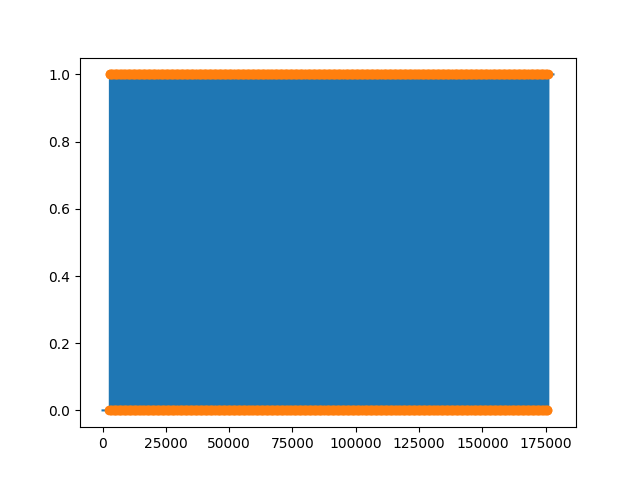

In [50]:
plt.figure()
plt.plot(emg_df['Trigger_Wulpus'])
plt.plot(wulpus_bloks, emg_df['Trigger_Wulpus'].loc[wulpus_bloks], marker='o', linestyle='none')
plt.show()

In [51]:
combined_df = combined_df.loc[idx_wulpus[0] - 490: combined_df[combined_df['Transducer_Data'].isna() == False].index[-1], :]

In [52]:
print(f'Acquired: {acquired_samples} for Wulpus')

Acquired: 15999 for Wulpus


In [53]:
combined_df[combined_df['Missing_Tx']==0]

index         Ch1           Ch2          Ch3          Ch4        Ch5  \
2379      4758 -815.749146 -39173.445312 -5933.006836  2305.626953 -51.935513   
2389      4778 -812.252380 -39075.058594 -5935.152344  2306.381836 -52.213669   
2399      4798 -808.080017 -38233.875000 -5938.490234  2298.990967 -51.736832   
2409      4818 -805.099792 -39070.328125 -5947.391113  2310.951660 -51.856041   
2419      4838 -808.636353 -39363.582031 -5939.046387  2304.395020 -51.697094   
...        ...         ...           ...          ...          ...        ...   
176059  352118 -813.841797 -16287.127930 -5431.374023  1413.186401 -51.458675   
176065  352130 -814.716003  -1568.714722 -4658.222168  1214.186401 -52.014988   
176071  352142 -815.272339 -34605.382812 -6054.123047  2307.852051 -52.094460   
176077  352154 -819.126770  -2203.027344 -4073.540283    46.292942 -51.816303   
176084  352168 -812.888123 -20903.507812 -5870.500977  2301.454590 -51.418941   

              Ch6        Ch7          Ch8    Timestamp  \
2379   -54.399174 -82.969666 -4522.005859   707.325317   
2389   -54.717064 -82.651772 -4524.071777   707.366760   
2399   -54.756802 -83.009399 -4524.588379   707.385864   
2409   -54.279964 -83.208084 -4529.833984   707.394348   
2419   -54.558117 -83.168350 -4527.409668   707.419739   
...           ...        ...          ...          ...   
176059 -54.677326 -83.287560 -4580.656738  1054.127563   
176065 -54.359436 -83.128609 -4539.251465  1054.134399   
176071 -54.558117 -83.208084 -4691.918457  1054.144897   
176077 -54.279964 -83.088875 -4374.066895  1054.144897   
176084 -54.478645 -82.929932 -4639.983398  1054.149170   

        Timestamp_reconstructed  Trigger_Wulpus  EMG_counter  Transducer  \
2379                 707.321777             0.0       2379.0         0.0   
2389                 707.343079             0.0       2389.0         0.0   
2399                 707.374948             0.0       2399.0         0.0   
2409                 707.388288             0.0       2409.0         0.0   
2419                 707.412484             0.0       2419.0         0.0   
...                         ...             ...          ...         ...   
176059              1054.116891             0.0     176059.0         0.0   
176065              1054.129517             0.0     176065.0         0.0   
176071              1054.135899             0.0     176071.0         0.0   
176077              1054.144897             0.0     176077.0         0.0   
176084              1054.147034             1.0     176084.0         0.0   

                                          Transducer_Data  US acq_num_array  \
2379    [0, 0, -1, -8, -13, 0, 6, 6, 8, 9, 7, 7, 7, 7,...               0.0   
2389    [0, 0, -2, -44, -211, -377, -433, -457, -480, ...               1.0   
2399    [0, 0, -2, -41, -204, -371, -429, -455, -475, ...               2.0   
2409    [0, 0, -2, -43, -205, -368, -426, -452, -473, ...               3.0   
2419    [0, 0, -2, -40, -198, -358, -416, -444, -470, ...               4.0   
...                                                   ...               ...   
176059  [0, 0, -2, -50, -223, -371, -419, -445, -466, ...           17375.0   
176065  [0, 0, -3, -49, -216, -364, -419, -447, -469, ...           17376.0   
176071  [0, 0, -1, -23, -163, -348, -415, -440, -462, ...           17377.0   
176077  [0, 0, -1, -33, -193, -371, -427, -449, -471, ...           17378.0   
176084  [0, 0, -2, -38, -186, -334, -398, -433, -461, ...           17379.0   

        Missing_Tx  
2379           0.0  
2389           0.0  
2399           0.0  
2409           0.0  
2419           0.0  
...            ...  
176059         0.0  
176065         0.0  
176071         0.0  
176077         0.0  
176084         0.0  

[16000 rows x 17 columns]

In [54]:
combined_df[combined_df['Missing_Tx']==1]

index         Ch1           Ch2          Ch3          Ch4        Ch5  \
20372   40744 -812.133179  -1432.379028 -4864.613281  1262.187988 -52.054722   
20382   40764 -812.451050  -1997.709229 -5080.461426  1448.949219 -51.895779   
20392   40784 -808.517151  -2060.453125 -5200.862793  1564.145142 -51.617622   
20403   40806 -809.947632  -2127.965332 -4481.116699   652.710571 -51.895779   
20413   40826 -822.305664  -2132.892578 -4489.858887   678.737976 -51.895779   
...       ...         ...           ...          ...          ...        ...   
51611  103222 -817.616760 -11702.020508 -5155.881348  1057.545288 -52.094460   
51621  103242 -818.808899 -11720.895508 -5123.813965  1056.313477 -52.054722   
51631  103262 -821.312256 -11642.336914 -5142.648926  1074.155151 -51.776569   
51641  103282 -812.252380 -11499.841797 -5134.185059   999.569885 -52.094460   
51651  103302 -810.146362 -11390.208984 -5115.190918  1065.572144 -51.895779   

             Ch6        Ch7          Ch8   Timestamp  Timestamp_reconstructed  \
20372 -54.518383 -83.128609 -4631.559082  743.294250               743.288208   
20382 -54.359436 -82.731247 -4662.314941  743.294250               743.293701   
20392 -55.670738 -83.367027 -4678.766113  743.311340               743.305847   
20403 -54.915745 -83.168350 -4556.934082  743.330322               743.327611   
20413 -55.074692 -82.810722 -4569.769043  743.364624               743.352373   
...          ...        ...          ...         ...                      ...   
51611 -54.717064 -82.651772 -4607.479004  805.627991               805.626840   
51621 -54.756802 -83.247818 -4606.962402  805.647583               805.639186   
51631 -54.399174 -83.128609 -4610.618164  805.662720               805.662720   
51641 -54.717064 -83.009399 -4617.253906  805.699707               805.692522   
51651 -54.756802 -82.770981 -4617.611328  805.702515               805.702114   

       Trigger_Wulpus  EMG_counter  Transducer Transducer_Data  \
20372             1.0      20372.0         0.0             NaN   
20382             1.0      20382.0         0.0             NaN   
20392             0.0      20392.0         0.0             NaN   
20403             0.0      20403.0         0.0             NaN   
20413             0.0      20413.0         0.0             NaN   
...               ...          ...         ...             ...   
51611             0.0      51611.0         0.0             NaN   
51621             0.0      51621.0         0.0             NaN   
51631             0.0      51631.0         0.0             NaN   
51641             0.0      51641.0         0.0             NaN   
51651             0.0      51651.0         0.0             NaN   

       US acq_num_array  Missing_Tx  
20372            1797.0         1.0  
20382            1798.0         1.0  
20392            1799.0         1.0  
20403            1800.0         1.0  
20413            1801.0         1.0  
...                 ...         ...  
51611            4917.0         1.0  
51621            4918.0         1.0  
51631            4919.0         1.0  
51641            4920.0         1.0  
51651            4921.0         1.0  

[1380 rows x 17 columns]

In [55]:
from scipy import signal as ss
# Filter Ultrasound Data
f_low = 0.55 * US_PRR
f_high = 1.45 * US_PRR

b, a = ss.butter(4, [f_low / (US_FS / 2), f_high / (US_FS / 2)], btype='bandpass')
index_not_nan = combined_df[combined_df['Transducer_Data'].isna()==False].index
data_filtered = ss.filtfilt(b, a, np.vstack(combined_df.loc[index_not_nan, 'Transducer_Data']))

# Hilbert Envelope Extraction
data_env = np.abs(hilbert(data_filtered, axis=1))

# Create a copy of the DataFrame for processed data
combined_df_proc = combined_df.copy()

# Assign filtered and envelope data to the new DataFrame
combined_df_proc.loc[index_not_nan, 'Transducer_Data_Filt'] = pd.Series(list(data_filtered), index=index_not_nan)
combined_df_proc.loc[index_not_nan, 'Transducer_Data_Hilb'] = pd.Series(list(data_env), index=index_not_nan)



In [56]:
combined_df_proc[combined_df_proc['Missing_Tx']==1]


index         Ch1           Ch2          Ch3          Ch4        Ch5  \
20372   40744 -812.133179  -1432.379028 -4864.613281  1262.187988 -52.054722   
20382   40764 -812.451050  -1997.709229 -5080.461426  1448.949219 -51.895779   
20392   40784 -808.517151  -2060.453125 -5200.862793  1564.145142 -51.617622   
20403   40806 -809.947632  -2127.965332 -4481.116699   652.710571 -51.895779   
20413   40826 -822.305664  -2132.892578 -4489.858887   678.737976 -51.895779   
...       ...         ...           ...          ...          ...        ...   
51611  103222 -817.616760 -11702.020508 -5155.881348  1057.545288 -52.094460   
51621  103242 -818.808899 -11720.895508 -5123.813965  1056.313477 -52.054722   
51631  103262 -821.312256 -11642.336914 -5142.648926  1074.155151 -51.776569   
51641  103282 -812.252380 -11499.841797 -5134.185059   999.569885 -52.094460   
51651  103302 -810.146362 -11390.208984 -5115.190918  1065.572144 -51.895779   

             Ch6        Ch7          Ch8   Timestamp  Timestamp_reconstructed  \
20372 -54.518383 -83.128609 -4631.559082  743.294250               743.288208   
20382 -54.359436 -82.731247 -4662.314941  743.294250               743.293701   
20392 -55.670738 -83.367027 -4678.766113  743.311340               743.305847   
20403 -54.915745 -83.168350 -4556.934082  743.330322               743.327611   
20413 -55.074692 -82.810722 -4569.769043  743.364624               743.352373   
...          ...        ...          ...         ...                      ...   
51611 -54.717064 -82.651772 -4607.479004  805.627991               805.626840   
51621 -54.756802 -83.247818 -4606.962402  805.647583               805.639186   
51631 -54.399174 -83.128609 -4610.618164  805.662720               805.662720   
51641 -54.717064 -83.009399 -4617.253906  805.699707               805.692522   
51651 -54.756802 -82.770981 -4617.611328  805.702515               805.702114   

       Trigger_Wulpus  EMG_counter  Transducer Transducer_Data  \
20372             1.0      20372.0         0.0             NaN   
20382             1.0      20382.0         0.0             NaN   
20392             0.0      20392.0         0.0             NaN   
20403             0.0      20403.0         0.0             NaN   
20413             0.0      20413.0         0.0             NaN   
...               ...          ...         ...             ...   
51611             0.0      51611.0         0.0             NaN   
51621             0.0      51621.0         0.0             NaN   
51631             0.0      51631.0         0.0             NaN   
51641             0.0      51641.0         0.0             NaN   
51651             0.0      51651.0         0.0             NaN   

       US acq_num_array  Missing_Tx Transducer_Data_Filt Transducer_Data_Hilb  
20372            1797.0         1.0                  NaN                  NaN  
20382            1798.0         1.0                  NaN                  NaN  
20392            1799.0         1.0                  NaN                  NaN  
20403            1800.0         1.0                  NaN                  NaN  
20413            1801.0         1.0                  NaN                  NaN  
...                 ...         ...                  ...                  ...  
51611            4917.0         1.0                  NaN                  NaN  
51621            4918.0         1.0                  NaN                  NaN  
51631            4919.0         1.0                  NaN                  NaN  
51641            4920.0         1.0                  NaN                  NaN  
51651            4921.0         1.0                  NaN                  NaN  

[1380 rows x 19 columns]

In [57]:
def plot_sync_emg_us(df):

    # plotting some data as example
    fig, axs = plt.subplots(3, 1, sharex=True)
    plt.subplots_adjust(hspace=0.1)

    # Overall x-axis range (based on the entire combined_df)
    #x_min, x_max = combined_df['Timestamp_reconstructed'].iloc[0], combined_df['Timestamp_reconstructed'].iloc[-1]
    #x_min, x_max = df.index[0], df.index[-1]
    x_min, x_max = df.index[0], df.index[-1]
    print(x_min, x_max)
    ch_to_plot = [1]
    cnt_fig=0
    
    #axs[cnt_fig].plot(timestamps_emg, combined_df[f'Ch{cnt_fig+1}'].values)
    axs[cnt_fig].plot(df.index, df[f'Ch{ch_to_plot[cnt_fig]}'].values)
    
    axs[cnt_fig].set_xlim(x_min, x_max)
    axs[cnt_fig].set_title(f'EMG - Ch{ch_to_plot[cnt_fig]}')
    axs[cnt_fig].set_ylabel('Amplitude [uV]')

    cnt_fig +=1

    # Loop over the transducers
    imaging_depths = compute_us_imaging_depths()
    #print(np.where(np.isnan(np.vstack(combined_df['Transducer_Data_Hilb'])).all(axis=1))[0])

    
    # Filter the data for the current transducer
    tx = df[df['Transducer'] == 0]
    tx_start = df.index[0]
    tx_stop = df.index[-1]
    #tx_stop = tx.index[-1]
    
    #tx = combined_df.loc[tx_start:tx_stop:80]
    print(tx_start, tx_stop)
    # Identify rows with NaN 

    nan_rows =  tx[tx['Transducer_Data'].isna() == True]
    #print(nan_rows)
    
    print(f'Got NaNs for current transducer:{len(nan_rows)}')

    # Create a pandas Series with arrays of 400 NaNs for the affected rows
    nan_arrays = pd.Series([np.full(400, np.nan) for _ in range(len(nan_rows))], index=nan_rows.index)
    #zero_arrays = pd.Series([np.full(400, 0) for _ in range(len(nan_rows))], index=nan_rows.index)
    # Assign the new Series to the 'Transducer_Data_Hilb' column
    tx.loc[nan_rows.index, 'Transducer_Data'] = nan_arrays
    
    # Extract data for plotting
    us_array = np.vstack(tx['Transducer_Data']).T
    #print(f"Shape: {us_array.shape}")
    #print(f"Data type: {us_array.dtype}")
    #print(f"Array content: {us_array}")
    #print("Non-numeric entries in us_array:")
    #print(us_array[~np.isfinite(us_array)])
    #us_array = np.vstack(tx['Transducer_Data_Hilb'].fillna(np.nan)).T
    #print(np.shape(np.isnan(us_array)))
    # Configure colormap to handle NaNs

    #cmap.set_bad(color="red")  # Set NaNs to red
    # Define extent
    extent = [
        tx_start,
        tx_stop,
        imaging_depths[-1],
        imaging_depths[0],
    ]
    
    print(extent[0], extent[1])
    # Plot the transducer data
    axs[cnt_fig].imshow(
        us_array,
        #extent=extent,
        extent=[x_min, x_max,  imaging_depths[-1],  imaging_depths[0]],
        aspect="auto",
        cmap='grey',
        origin="upper",
        interpolation = "none", 
        #vmin=1, 
        
    )
    #axs[cnt_fig].set_xlim(x_min, x_max)
    axs[cnt_fig].set_ylabel("Depth [mm]")
        
    #axs[cnt_fig].plot(combined_df.index,combined_df['Trigger_gui'] )
    cnt_fig+=1
    axs[cnt_fig].plot(df.index, df['Trigger_Wulpus'].values)
    axs[cnt_fig].set_xlabel('Samples')
    axs[cnt_fig].set_xlim(x_min, x_max)
    #plt.tight_layout()
    plt.show()





In [58]:
def plot_sync_emg_us_discrete(df):

    # plotting some data as example
    fig, axs = plt.subplots(3, 1, sharex=True)
    plt.subplots_adjust(hspace=0.1)

    # Overall x-axis range (based on the entire combined_df)
    #x_min, x_max = combined_df['Timestamp_reconstructed'].iloc[0], combined_df['Timestamp_reconstructed'].iloc[-1]
    #x_min, x_max = df.index[0], df.index[-1]
    x_min, x_max = df.index[0], df.index[-1]
    print(x_min, x_max)
    ch_to_plot = [1]
    cnt_fig=0
    
    #axs[cnt_fig].plot(timestamps_emg, combined_df[f'Ch{cnt_fig+1}'].values)
    axs[cnt_fig].plot(df.index, df[f'Ch{ch_to_plot[cnt_fig]}'].values)
    
    axs[cnt_fig].set_xlim(x_min, x_max)
    axs[cnt_fig].set_title(f'EMG - Ch{ch_to_plot[cnt_fig]}')
    axs[cnt_fig].set_ylabel('Amplitude [uV]')

    cnt_fig +=1

    # Loop over the transducers
    imaging_depths = compute_us_imaging_depths()
    #print(np.where(np.isnan(np.vstack(combined_df['Transducer_Data_Hilb'])).all(axis=1))[0])

    
        # Step 1: Identify valid rows
    valid_rows = df['Transducer_Data'].notna()

    # Step 2: Prepare a full array with NaN for invalid rows
    # Initialize a full matrix with NaNs
    transducer_data_matrix = np.full((len(df), 400), np.nan)

    # Assign valid rows into the matrix
    transducer_data_matrix[valid_rows] = np.vstack(df.loc[valid_rows, 'Transducer_Data'].values)

    # Step 3: Define extent for the x-axis
    x_min, x_max = df.index[0], df.index[-1]
    y_min, y_max = imaging_depths[-1], imaging_depths[0] 

    axs[cnt_fig].imshow(
        transducer_data_matrix.T,  # Transpose to match rows with x-axis
        extent=[x_min, x_max, y_max, y_min],  # Ensure correct orientation
        aspect='auto',
        origin='upper',
        interpolation='none',
        cmap='grey',  # Use desired colormap
    )
        

    #axs[cnt_fig].set_xlim(x_min, x_max)
    axs[cnt_fig].set_ylabel("Depth [mm]")
        
    #axs[cnt_fig].plot(combined_df.index,combined_df['Trigger_gui'] )
    cnt_fig+=1
    axs[cnt_fig].plot(df.index, df['Trigger_Wulpus'].values)
    axs[cnt_fig].set_xlabel('Samples')
    axs[cnt_fig].set_xlim(x_min, x_max)
    #plt.tight_layout()
    plt.show()

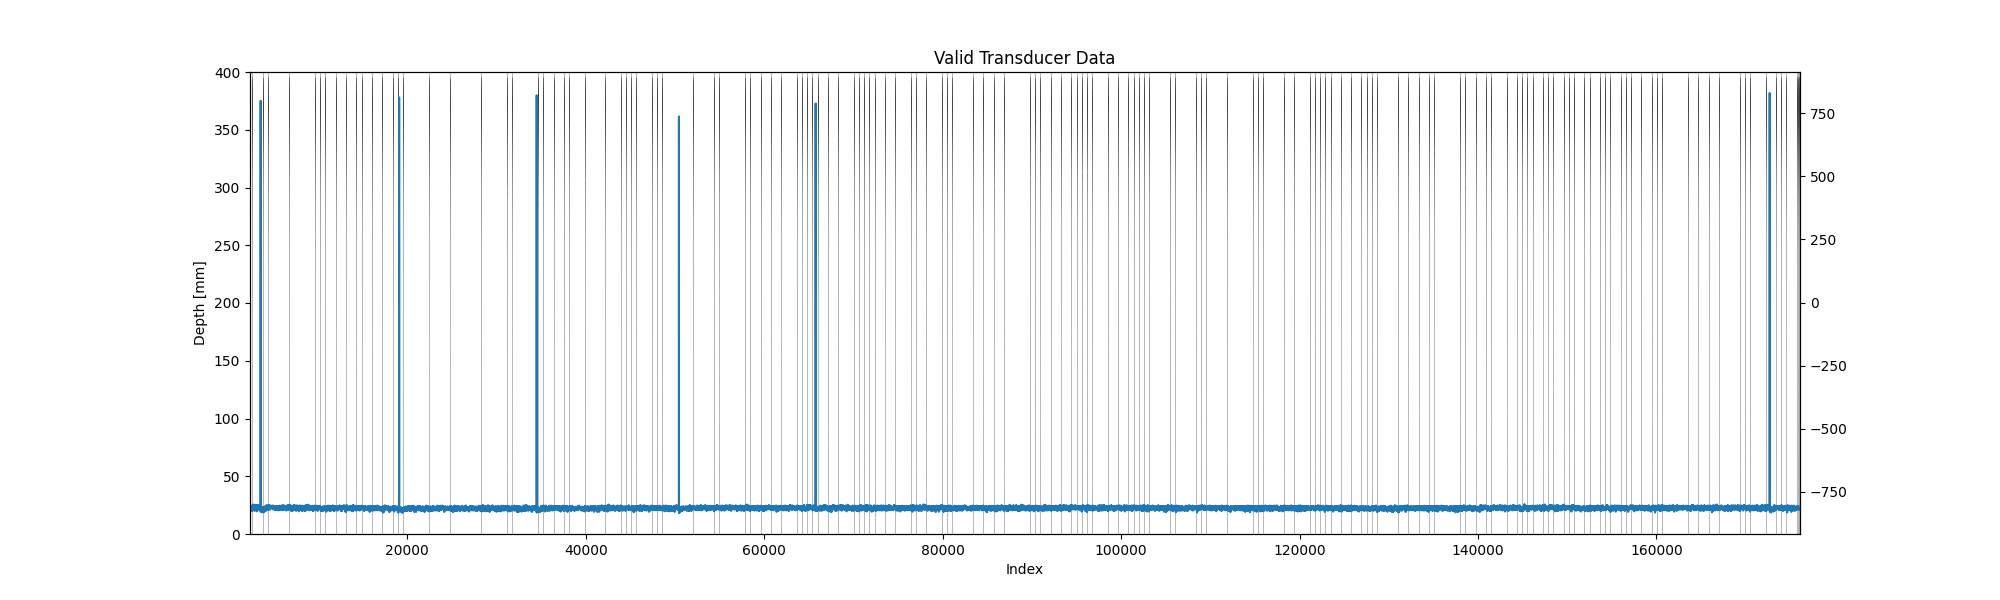

In [59]:
# Step 1: Identify valid rows
valid_rows = combined_df_proc['Transducer_Data'].notna()

# Step 2: Prepare a full array with NaN for invalid rows
# Initialize a full matrix with NaNs
transducer_data_matrix = np.full((len(combined_df_proc), 400), np.nan)

# Assign valid rows into the matrix
transducer_data_matrix[valid_rows] = np.vstack(combined_df_proc.loc[valid_rows, 'Transducer_Data'].values)

# Step 3: Define extent for the x-axis
x_min, x_max = combined_df_proc.index[0], combined_df_proc.index[-1]
y_min, y_max = 400, 0  # Adjust as needed for the depth axis

# Step 4: Plot using imshow
fig, ax = plt.subplots(figsize=(20, 6))
ax.imshow(
    transducer_data_matrix.T,  # Transpose to match rows with x-axis
    extent=[x_min, x_max, y_max, y_min],  # Ensure correct orientation
    aspect='auto',
    origin='upper',
    interpolation='none',
    cmap='grey',  # Use desired colormap
)

# Step 5: Configure labels and show the plot
ax.set_xlabel('Index')
ax.set_ylabel('Depth [mm]')
ax.set_title('Valid Transducer Data')


ax2= ax.twinx()
ax2.plot(combined_df['Ch1'])
plt.show()


In [60]:
combined_df_proc

index         Ch1           Ch2          Ch3          Ch4        Ch5  \
2379      4758 -815.749146 -39173.445312 -5933.006836  2305.626953 -51.935513   
2380      4760 -815.669678 -43415.468750 -5961.537598  2389.073486 -51.935513   
2381      4762 -816.067078 -36435.960938 -5938.927246  2373.894043 -51.935513   
2382      4764 -816.384949 -10867.357422 -5403.836426  1939.574829 -52.094460   
2383      4766 -816.226013   -303.586334 -4166.563477   771.601990 -52.094460   
...        ...         ...           ...          ...          ...        ...   
176080  352160 -818.332031 -26518.107422 -5900.502441  2076.665527 -51.736832   
176081  352162 -818.729370 -35104.750000 -6070.137207  2432.306641 -51.776569   
176082  352164 -818.133362 -40735.839844 -6120.681641  2506.931641 -51.736832   
176083  352166 -815.312073 -39832.910156 -6101.687988  2483.884521 -51.816303   
176084  352168 -812.888123 -20903.507812 -5870.500977  2301.454590 -51.418941   

              Ch6        Ch7          Ch8    Timestamp  \
2379   -54.399174 -82.969666 -4522.005859   707.325317   
2380   -54.597855 -82.929932 -4526.535645   707.325317   
2381   -54.915745 -83.168350 -4517.952637   707.325317   
2382   -54.518383 -83.128609 -4478.653320   707.325317   
2383   -54.796535 -83.088875 -4333.019043   707.325317   
...           ...        ...          ...          ...   
176080 -54.558117 -83.287560 -4668.752441  1054.149170   
176081 -54.597855 -83.128609 -4693.746582  1054.149170   
176082 -54.597855 -82.890190 -4702.170898  1054.149170   
176083 -54.717064 -83.009399 -4679.401855  1054.149170   
176084 -54.478645 -82.929932 -4639.983398  1054.149170   

        Timestamp_reconstructed  Trigger_Wulpus  EMG_counter  Transducer  \
2379                 707.321777             0.0       2379.0         0.0   
2380                 707.322283             0.0       2380.0         NaN   
2381                 707.322789             0.0       2381.0         NaN   
2382                 707.323295             0.0       2382.0         NaN   
2383                 707.323800             0.0       2383.0         NaN   
...                         ...             ...          ...         ...   
176080              1054.145813             0.0     176080.0         NaN   
176081              1054.146118             0.0     176081.0         NaN   
176082              1054.146423             0.0     176082.0         NaN   
176083              1054.146729             0.0     176083.0         NaN   
176084              1054.147034             1.0     176084.0         0.0   

                                          Transducer_Data  US acq_num_array  \
2379    [0, 0, -1, -8, -13, 0, 6, 6, 8, 9, 7, 7, 7, 7,...               0.0   
2380                                                  NaN               NaN   
2381                                                  NaN               NaN   
2382                                                  NaN               NaN   
2383                                                  NaN               NaN   
...                                                   ...               ...   
176080                                                NaN               NaN   
176081                                                NaN               NaN   
176082                                                NaN               NaN   
176083                                                NaN               NaN   
176084  [0, 0, -2, -38, -186, -334, -398, -433, -461, ...           17379.0   

        Missing_Tx                               Transducer_Data_Filt  \
2379           0.0  [0.0014766374748532707, 2.698642619957518, 5.0...   
2380           NaN                                                NaN   
2381           NaN                                                NaN   
2382           NaN                                                NaN   
2383           NaN                                                NaN   
...            ...                     

2379 176084
2379 176084
Got NaNs for current transducer:1380
2379 176084


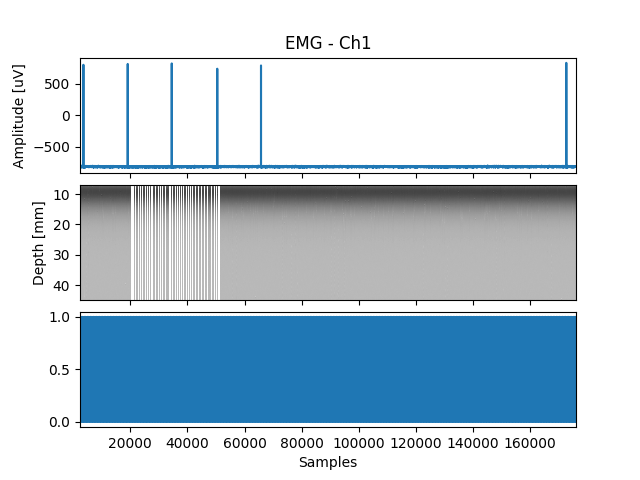

In [61]:
plot_sync_emg_us(combined_df_proc)                 # up to 175000 works


2379 176084


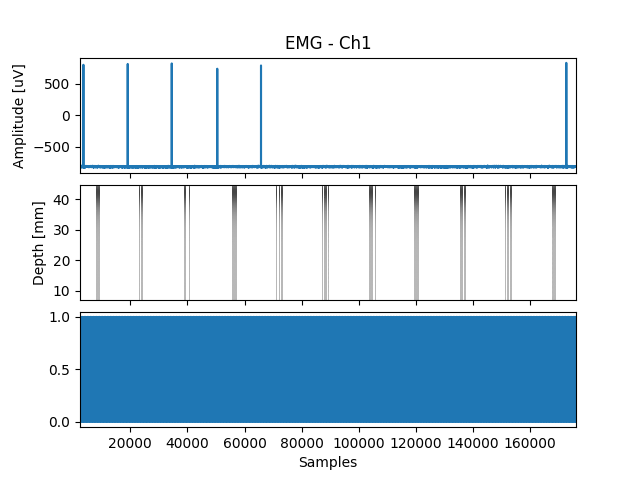

In [62]:
plot_sync_emg_us_discrete(combined_df_proc) 

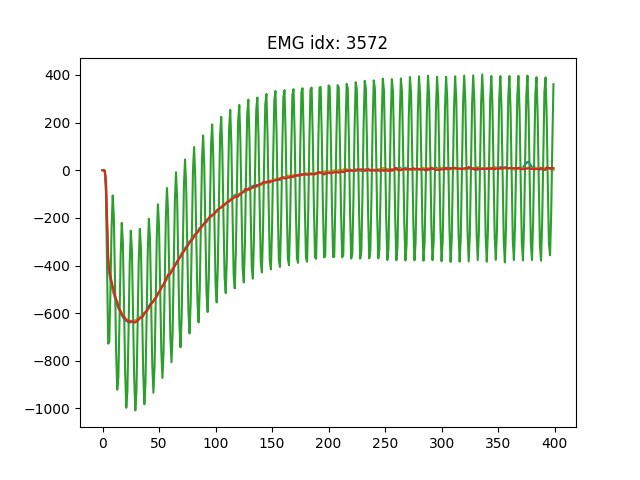

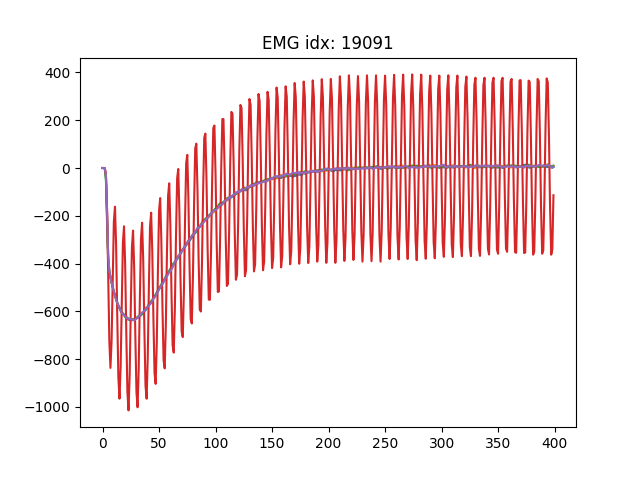

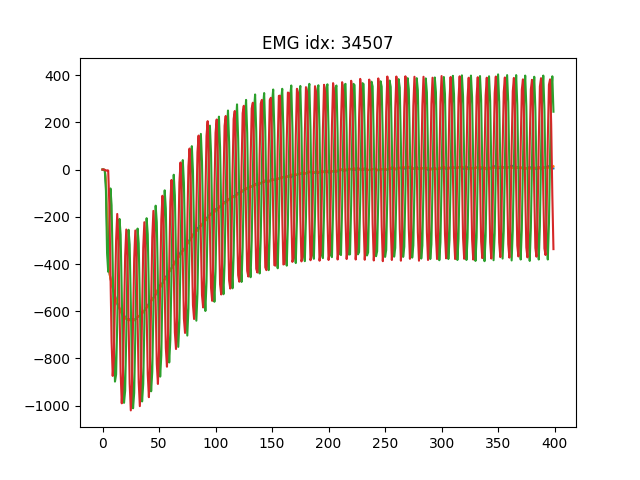

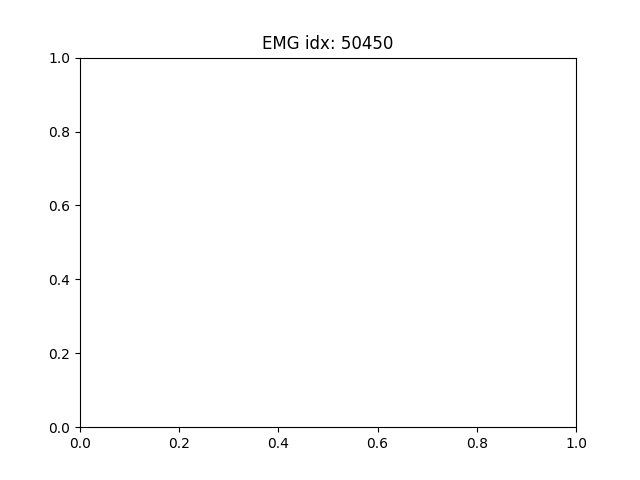

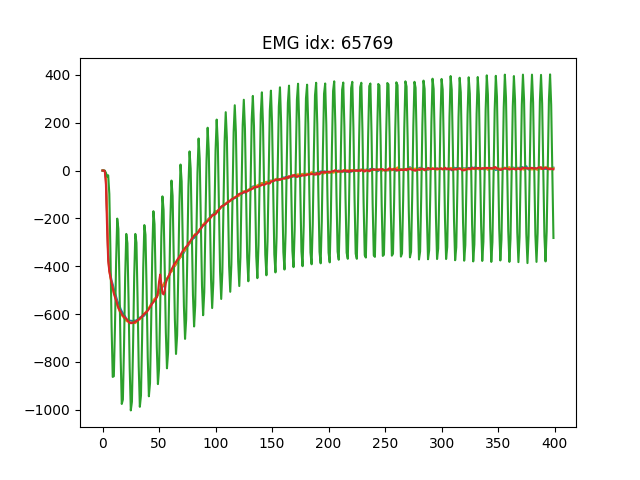

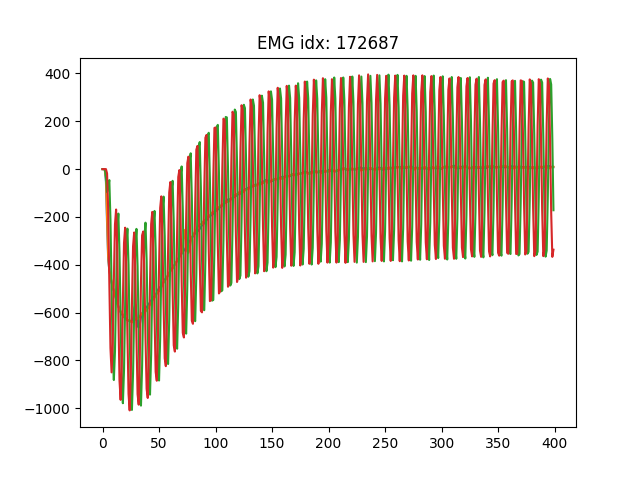

In [63]:
for i in range(len(emg_idx_effect)):

    tx_data_curr= combined_df_proc.loc[emg_idx_effect[i]-20:emg_idx_effect[i]+20][combined_df_proc.loc[emg_idx_effect[i]-20:emg_idx_effect[i]+20]['Transducer_Data'].isna() == False]['Transducer_Data']
    plt.figure()
    for curr_data in tx_data_curr:
        plt.plot(curr_data)
    plt.title(f"EMG idx: {emg_idx_effect[i]}")

172667 176084
172667 176084
Got NaNs for current transducer:0
172667 176084


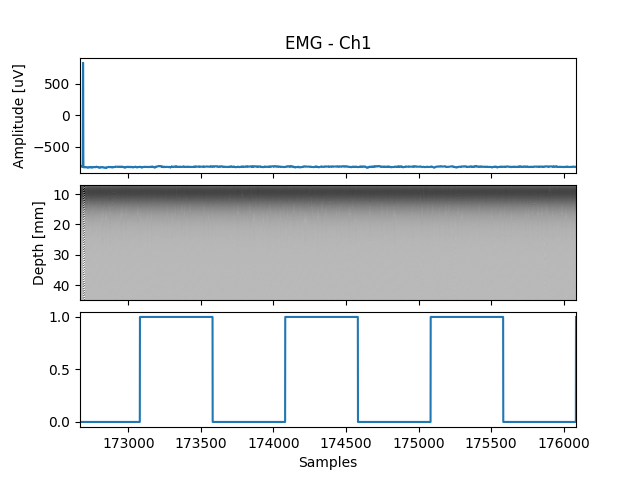

In [64]:
#plot_sync_emg_us(combined_df_proc.loc[:150000])
plot_sync_emg_us(combined_df_proc.loc[emg_idx_effect[-1]-20:])

2379 150000
2379 150000
Got NaNs for current transducer:1380
2379 150000


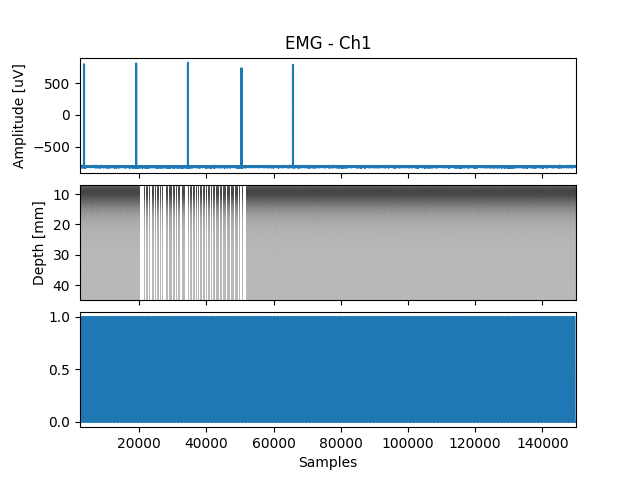

In [65]:
plot_sync_emg_us(combined_df.loc[:150000])

34487 50470
34487 50470
Got NaNs for current transducer:644
34487 50470


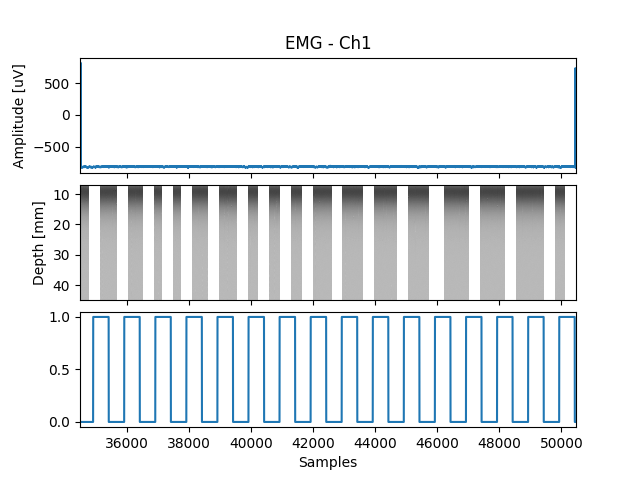

In [66]:
plot_sync_emg_us(combined_df_proc.loc[emg_idx_effect[-4]-20 : emg_idx_effect[-3]+20])         #until 192400 works, then breaks OKAY

C:\Users\giusy\AppData\Local\Temp\ipykernel_33900\1938840966.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, sharex=True)


3532 19151
3532 19151
Got NaNs for current transducer:0
3532 19151


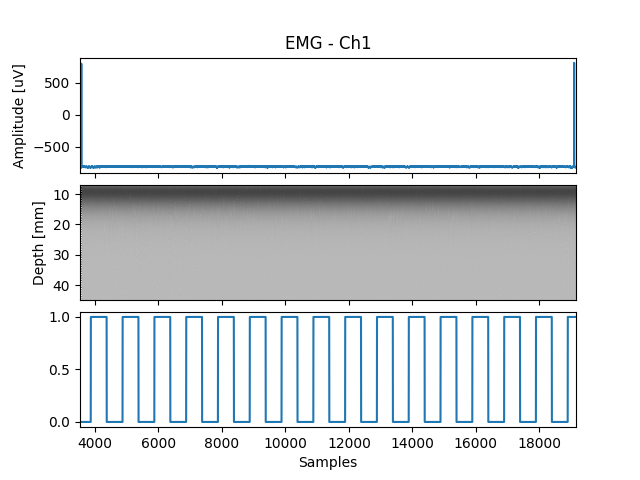

In [67]:
plot_sync_emg_us(combined_df_proc.loc[emg_idx_effect[0]-40 : emg_idx_effect[1]+60])         #until 192400 works, then breaks OKAY

172627 176084
172627 176084
Got NaNs for current transducer:0
172627 176084


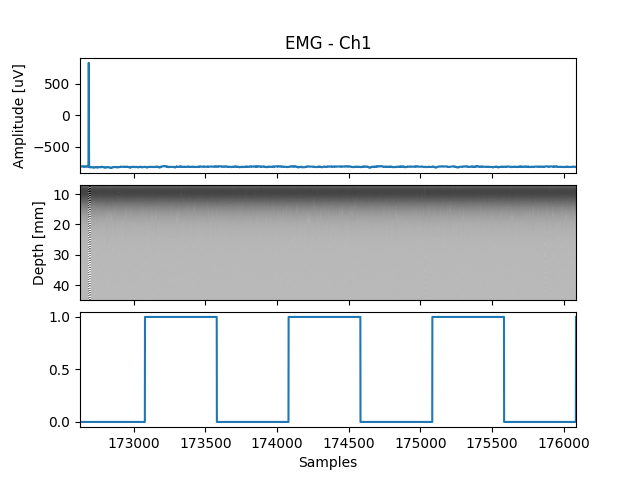

In [73]:
plot_sync_emg_us(combined_df_proc.loc[emg_idx_effect[-1]-60:])


2379 176084
2379 176084
Got NaNs for current transducer:1380
2379 176084


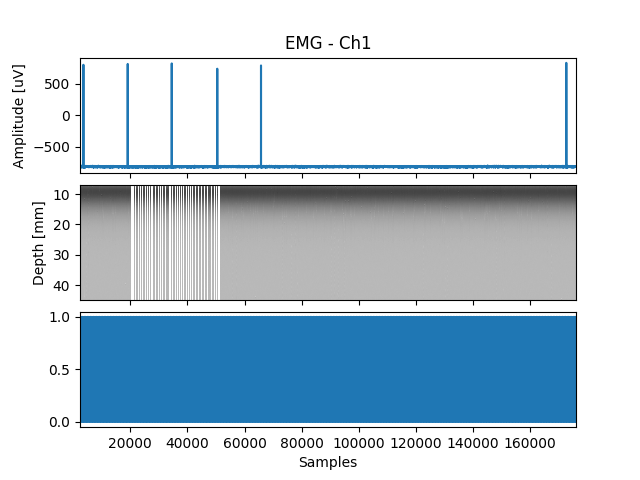

In [69]:
plot_sync_emg_us(combined_df_proc)

In [70]:
for i in range(len(emg_idx_effect)):

    tx_data_curr= combined_df_proc.loc[emg_idx_effect[i]-15:emg_idx_effect[i]+15][combined_df_proc.loc[emg_idx_effect[i]-15:emg_idx_effect[i]+15]['Transducer_Data'].isna() == False]
    #['Transducer_Data']
    print('US possible idx:')
    print(tx_data_curr['index'])
    print('EMG idx')
    print(combined_df_proc.loc[emg_idx_effect[i],['index']].values[0])
    print('...')

US possible idx:
3561    7122
3571    7142
3581    7162
Name: index, dtype: int32
EMG idx
7144
...
US possible idx:
19081    38162
19091    38182
19101    38202
Name: index, dtype: int32
EMG idx
38182
...
US possible idx:
34500    69000
34510    69020
34520    69040
Name: index, dtype: int32
EMG idx
69014
...
US possible idx:
Series([], Name: index, dtype: int32)
EMG idx
100900
...
US possible idx:
65758    131516
65768    131536
65778    131556
Name: index, dtype: int32
EMG idx
131538
...
US possible idx:
172680    345360
172690    345380
172700    345400
Name: index, dtype: int32
EMG idx
345374
...


In [71]:
# just for seekness, look for correlations
pattern_wave = combined_df_proc.loc[3581, 'Transducer_Data']
tx_idxs = combined_df_proc[combined_df_proc['Transducer'].isna() == False].index
mses = []
for curr_tx_idx in tx_idxs:
    curr_tx_data = combined_df_proc.loc[curr_tx_idx, 'Transducer_Data']
    mse = np.mean((pattern_wave - curr_tx_data) ** 2)
    print(f"Mean Squared Error: {mse}")
    mses.append(mse)


Mean Squared Error: 3368.015
Mean Squared Error: 3734.7075
Mean Squared Error: 3836.6
Mean Squared Error: 4068.5475
Mean Squared Error: 4234.5575
Mean Squared Error: 4183.15
Mean Squared Error: 4111.3575
Mean Squared Error: 3948.335
Mean Squared Error: 4008.33
Mean Squared Error: 3839.825
Mean Squared Error: 4414.4175
Mean Squared Error: 4262.9825
Mean Squared Error: 4139.6775
Mean Squared Error: 4161.005
Mean Squared Error: 4368.665
Mean Squared Error: 4498.1025
Mean Squared Error: 3843.1025
Mean Squared Error: 4291.7175
Mean Squared Error: 4377.445
Mean Squared Error: 4101.965
Mean Squared Error: 3322.2625
Mean Squared Error: 4354.705
Mean Squared Error: 4005.405
Mean Squared Error: 4245.9
Mean Squared Error: 4431.8975
Mean Squared Error: 3769.015
Mean Squared Error: 4001.9975
Mean Squared Error: 4159.3075
Mean Squared Error: 4550.38
Mean Squared Error: 3765.315
Mean Squared Error: 3522.3875
Mean Squared Error: 4182.365
Mean Squared Error: 3997.605
Mean Squared Error: 4365.03
Mean Sq

In [296]:
from scipy.signal import correlate
from scipy.stats import pearsonr

pattern_wave = combined_df_proc.loc[3581, 'Transducer_Data']
tx_idxs = combined_df_proc[combined_df_proc['Transducer'].isna() == False].index
corrs = []
for curr_tx_idx in tx_idxs:
    curr_tx_data = combined_df_proc.loc[curr_tx_idx, 'Transducer_Data']
    cross_corr = correlate(pattern_wave, curr_tx_data, mode='full')
    lag = np.argmax(cross_corr) - len(pattern_wave) + 1
    corrs.append(lag)



ValueError: in1 and in2 should have the same dimensionality

In [852]:

from scipy.stats import pearsonr

pattern_wave = combined_df_proc.loc[3581, 'Transducer_Data']
tx_idxs = combined_df_proc[combined_df_proc['Transducer'].isna() == False].index
corrs = []
for curr_tx_idx in tx_idxs:
    curr_tx_data = combined_df_proc.loc[curr_tx_idx, 'Transducer_Data']
    pearson, _ = pearsonr(pattern_wave, curr_tx_data)
    print("..")

    corrs.append(pearson)

..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
.

C:\Users\giusy\AppData\Local\Temp\ipykernel_21676\173732093.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson, _ = pearsonr(pattern_wave, curr_tx_data)


..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
.

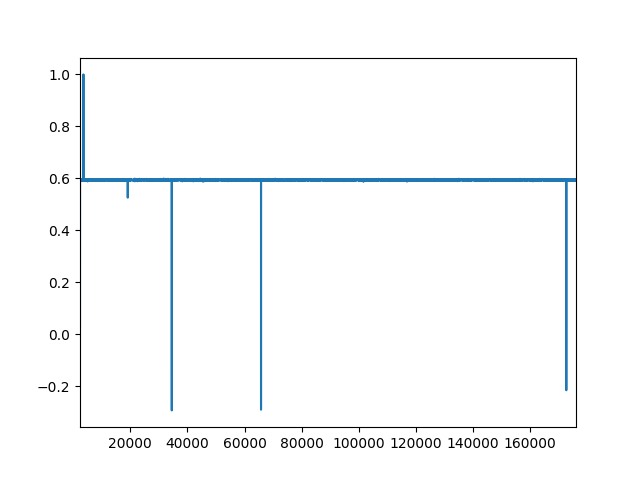

In [853]:
plt.figure()
plt.plot(tx_idxs, corrs)
plt.xlim(tx_idxs[0], tx_idxs[-1])
plt.show()

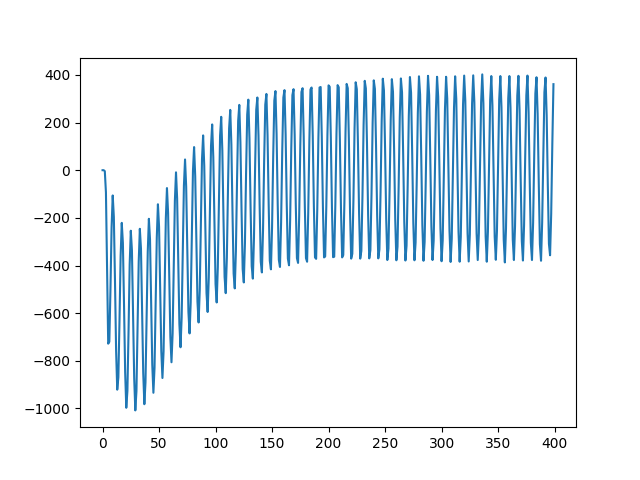

In [828]:
plt.figure()
plt.plot(combined_df_proc.loc[3581, 'Transducer_Data'])

In [814]:

pattern_wave


array([    0,     0,    -4,   -93,  -421,  -728,  -720,  -501,  -240,
        -106,  -196,  -462,  -758,  -921,  -869,  -631,  -360,  -221,
        -305,  -563,  -847,  -997,  -926,  -678,  -396,  -254,  -336,
        -598,  -872, -1008,  -927,  -668,  -384,  -246,  -329,  -583,
        -851,  -982,  -890,  -628,  -342,  -204,  -290,  -550,  -816,
        -934,  -829,  -561,  -282,  -143,  -237,  -495,  -760,  -872,
        -760,  -487,  -202,   -75,  -179,  -438,  -699,  -806,  -686,
        -409,  -128,    -9,  -118,  -385,  -646,  -743,  -618,  -341,
         -65,    45,   -69,  -338,  -595,  -685,  -555,  -274,    -3,
          97,   -25,  -296,  -552,  -639,  -505,  -219,    46,   146,
          18,  -259,  -515,  -595,  -450,  -163,   103,   192,    54,
        -223,  -478,  -555,  -407,  -120,   144,   224,    82,  -198,
        -448,  -516,  -367,   -78,   176,   253,   107,  -178,  -434,
        -496,  -339,   -46,   207,   274,   117,  -168,  -415,  -471,
        -307,   -14,